In [1]:
import pandas as pd
import re
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from math import radians, sin, cos, asin, sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity ='all'

pd.set_option('display.max_columns', None)    #显示所有列
pd.set_option('display.max_rows', 30)    #显示所有行
pd.set_option('max_colwidth',100)    #设置value的显示长度为100，默认为50

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier

# 集成分类库和投票方法库
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
# StratifiedKFold：适用于有标签数据集的交叉检验数据集划分方法。cross_val_score：通过交叉检验方法做模型效果评估。导入交叉检验算法
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [6]:
data_18_20 = pd.read_csv('dispatch_info_2.csv', encoding = 'UTF-8')
data_18_20.head(1)
data_18_20.shape

,ORDER_NO,SO_NOL,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME
0,LO2018010117781036,Z131712021151,T1712312225268,合肥美的洗衣机有限公司-内销,洗衣机事业部,4.12339,410.0,10.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:22:41,皖KF1887,17.5米车,陆友根,4.12339


(1517913, 24)

In [243]:
data_19 = pd.read_csv('dispatch_info.csv', encoding = 'UTF-8')
data_19.head(1)
data_19.shape

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT
0,LO2019010130861339,Z131812034501,T1812314353944,合肥美的洗衣机有限公司-内销,洗衣机事业部,176.777065,26605.0,349.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:05:16,陕AR3252,9.6米车(低栏),徐晨,176.777065,107.144716,33.074341


(731527, 26)

In [15]:
data_18_20.head(20)

,ORDER_NO,SO_NOL,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME
0,LO2018010117781036,Z131712021151,T1712312225268,合肥美的洗衣机有限公司-内销,洗衣机事业部,4.123390,410.0,10.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:22:41,皖KF1887,17.5米车,陆友根,4.123390
1,LO2018010117781037,Z131712021146,T1712312225268,合肥美的洗衣机有限公司-内销,洗衣机事业部,12.370170,1230.0,30.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:22:48,皖KF1887,17.5米车,陆友根,12.370170
2,LO2018010117781038,Z131712021153,T1712312225268,合肥美的洗衣机有限公司-内销,洗衣机事业部,8.246780,820.0,20.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:22:41,皖KF1887,17.5米车,陆友根,8.246780
3,LO2018010117781039,Z131712021149,T1712312225268,合肥美的洗衣机有限公司-内销,洗衣机事业部,2.551150,390.0,5.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:23:42,皖KF1887,17.5米车,陆友根,2.551150
4,LO2018010117781040,Z131712021141,T1712312225268,合肥美的洗衣机有限公司-内销,洗衣机事业部,8.234372,1254.0,19.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:23:34,皖KF1887,17.5米车,陆友根,8.234372
5,LO2018010117781042,Z231712032005,T1712312225268,无锡小天鹅股份有限公司-内销,洗衣机事业部,10.204600,1600.0,20.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:24:10,皖KF1887,17.5米车,陆友根,10.204600
6,LO2018010117781043,Z231712031988,T1712312225268,无锡小天鹅股份有限公司-内销,洗衣机事业部,12.740550,1230.0,30.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:22:28,皖KF1887,17.5米车,陆友根,12.740550
7,LO2018010117781044,Z231712031987,T1712312225268,无锡小天鹅股份有限公司-内销,洗衣机事业部,13.147950,1320.0,30.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:21:10,皖KF1887,17.5米车,陆友根,13.147950
8,LO2018010117781045,Z231712031989,T1712312225268,无锡小天鹅股份有限公司-内销,洗衣机事业部,4.481750,760.0,10.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:24:19,皖KF1887,17.5米车,陆友根,4.481750
9,LO2018010117781046,Z231712032008,T1712312225268,无锡小天鹅股份有限公司-内销,洗衣机事业部,26.395000,2960.0,60.0,广东省,肇庆市,鼎湖区,坑口街道,广东省肇庆市鼎湖区星湖大道鼎湖新城75-5区鸿景驾校旁美的仓库,广东省,广州市,花都区,轻货,B,2018-01-01 10:27:00,2018-01-02 18:24:19,皖KF1887,17.5米车,陆友根,26.395000


In [244]:
total = data_19['RECEIVE_STREET'].isnull().sum()
total

3252

In [245]:
data_19 = data_19.drop(index = (data_19[data_19['RECEIVE_STREET'].isnull()].index) )
data_19.shape

(728275, 26)

In [246]:
data_19 = data_19[data_19['ORDER_NO'] != 'LO2019051236320475']    #  有一个时间有问题  0016 年的数据
data_19 = data_19[data_19['DO_NO']!= '0']

###   基于发车单和收货街道聚合

In [247]:
a = data_19.groupby(['DO_NO','RECEIVE_STREET'])
pd.DataFrame(a)

,0,1
0,"(T1702111035440, 北辰区)",ORDER_NO SO_NO DO_NO CUSTOMER \ 490084 LO201909084...
1,"(T1702111035818, 亭湖区)",ORDER_NO SO_NO DO_NO CUSTOMER \ 490086 LO201909084...
2,"(T1702111035868, 灯塔)",ORDER_NO SO_NO DO_NO CUSTOMER \ 490083 LO201909084...
3,"(T1707271604891, 钟岭街道办事处（金巢开发区）)",ORDER_NO SO_NO DO_NO CUSTOMER \ 536256 LO201910014...
4,"(T1707281606693, 九龙镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 536254 LO201910014...
...,...,...
170815,"(T2006158000048, 大白街道)",ORDER_NO SO_NO DO_NO CUSTOMER \ 556323 LO201910164...
170816,"(T2006168003800, 表白寺镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 558003 LO201910174...
170817,"(T2006168004609, 秋长街道)",ORDER_NO SO_NO DO_NO CUSTOMER \ 558358 LO201910174...
170818,"(T2006168005918, 小蚌埠镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 558004 LO201910174...


In [31]:
data_19.groupby(['DO_NO','RECEIVE_STREET']
                )['PICK_UP_TIME'].min().reset_index().rename(columns = {'PICK_UP_TIME':'PICK_UP_EARLIST'}
                )

,DO_NO,RECEIVE_STREET,PICK_UP_EARLIST
0,T1702111035440,北辰区,2019-09-08 11:29:35
1,T1702111035818,亭湖区,2019-09-08 11:29:35
2,T1702111035868,灯塔,2019-09-08 11:29:35
3,T1707271604891,钟岭街道办事处（金巢开发区）,2019-10-01 15:48:06
4,T1707281606693,九龙镇,2019-10-01 15:48:06
...,...,...,...
170815,T2006158000048,大白街道,2019-10-17 09:31:48
170816,T2006168003800,表白寺镇,2019-10-16 09:45:45
170817,T2006168004609,秋长街道,2019-10-18 13:39:45
170818,T2006168005918,小蚌埠镇,2019-10-16 09:45:45


In [252]:
# data_19['PICK_UP_TIME' ] = pd.to_datetime( data_19['PICK_UP_TIME' ] , format='%Y-%m-%d %H:%M:%S')
data_19['PICK_UP_TIME' ] = data_19['PICK_UP_TIME' ].astype('datetime64')
data_19['PICK_UP_TIME' ]

0        2019-01-01 08:54:23
1        2019-01-01 08:54:23
2        2019-01-01 08:54:23
3        2019-01-01 08:01:54
4        2019-01-01 08:01:54
                 ...        
731522   2020-01-02 07:50:01
731523   2020-01-03 08:41:01
731524   2020-01-03 08:06:36
731525   2020-01-03 08:06:36
731526   2020-01-03 08:41:01
Name: PICK_UP_TIME, Length: 728274, dtype: datetime64[ns]

In [62]:
data_19 = data_19.drop( index = data_19[data_19['PICK_UP_TIME'] == '0016-11-14 09:29:10'].index)
data_19 = data_19.drop( index = data_19[data_19['PICK_UP_TIME'] == '2017-08-19 16:23:00'].index)
data_19 = data_19.drop( index = data_19[data_19['PICK_UP_TIME'] == '2018-12-09 12:48:28'].index)
data_19 = data_19.drop( index = data_19[data_19['PICK_UP_TIME'] == '2018-12-10 13:42:50'].index)

In [70]:
data_19[data_19['PICK_UP_TIME'] <= '2019-01-01 00:00:00']

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST
100,LO2019010130861960,Z121812063788,T1812314352092,合肥美的电冰箱有限公司-内销,冰箱事业部,132.624135,9184.0,311.0,湖北省,荆州市,沙市区,中山路街道,经济开发区深圳大道与沙岑路交叉口美安仓库,湖北省,荆州市,沙市区,轻货,B,2018-12-25 09:01:00,2019-01-01 15:20:48,鄂FL5070,17.5米车,胡耀廷,132.624135,112.339860,30.304400,2018-12-25 09:01:00,2019-01-01 15:21:30
101,LO2019010130861962,Z121812073773,T1812314352092,合肥美的电冰箱有限公司-内销,冰箱事业部,18.653250,1540.0,14.0,湖北省,荆州市,沙市区,中山路街道,经济开发区深圳大道与沙岑路交叉口美安仓库,湖北省,荆州市,沙市区,轻货,B,2018-12-25 09:01:00,2019-01-01 15:15:25,鄂FL5070,17.5米车,胡耀廷,18.653250,112.339860,30.304400,2018-12-25 09:01:00,2019-01-01 15:21:30
102,LO2019010130861965,Z121812073771,T1812314352092,合肥美的电冰箱有限公司-内销,冰箱事业部,40.661280,3300.0,30.0,湖北省,荆州市,沙市区,中山路街道,经济开发区深圳大道与沙岑路交叉口美安仓库,湖北省,荆州市,沙市区,轻货,B,2018-12-25 09:01:00,2019-01-01 15:13:36,鄂FL5070,17.5米车,胡耀廷,40.661280,112.339860,30.304400,2018-12-25 09:01:00,2019-01-01 15:21:30
103,LO2019010130861966,Z121812073772,T1812314352092,合肥美的电冰箱有限公司-内销,冰箱事业部,47.438160,3850.0,35.0,湖北省,荆州市,沙市区,中山路街道,经济开发区深圳大道与沙岑路交叉口美安仓库,湖北省,荆州市,沙市区,轻货,B,2018-12-25 09:01:00,2019-01-01 15:14:56,鄂FL5070,17.5米车,胡耀廷,47.438160,112.339860,30.304400,2018-12-25 09:01:00,2019-01-01 15:21:30
104,LO2019010130861968,Z121812063616,T1812314352092,合肥美的电冰箱有限公司-内销,冰箱事业部,4.158945,288.0,9.0,湖北省,荆州市,沙市区,中山路街道,经济开发区深圳大道与沙岑路交叉口美安仓库,湖北省,荆州市,沙市区,轻货,B,2018-12-25 09:01:00,2019-01-01 15:17:49,鄂FL5070,17.5米车,胡耀廷,4.158945,112.339860,30.304400,2018-12-25 09:01:00,2019-01-01 15:21:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44307,LO2019011431552088,Z171901018860,T1901144488818,芜湖美的厨卫电器制造有限公司-内销,厨房和热水事业部,30.520896,3571.2,192.0,河南省,驻马店市,驿城区,沙河店镇,关王庙乡开源街道办事处驻马店电子商务产业园,安徽省,芜湖市,鸠江区,轻货,B,2018-12-26 09:25:01,2019-01-17 09:28:42,豫Q23928,6.8米车,刘俊毅,30.520896,114.076364,33.038864,2018-12-26 09:25:01,2019-01-17 09:28:42
98191,LO2019021732527019,Z131902002427,T1902164664351,合肥美的洗衣机有限公司-内销,洗衣机事业部,74.493580,11388.0,150.0,河南省,驻马店市,驿城区,关王庙乡,开源街道办事处驻马店电子商务产业园,江苏省,苏州市,相城区,轻货,B,2018-12-19 09:19:35,2019-02-18 10:51:14,豫LG7269,17.5米车,林余良,74.493580,114.078798,33.038497,2018-12-19 09:19:35,2019-02-18 10:51:14
98193,LO2019021732527021,Z131902003519,T1902164664351,合肥美的洗衣机有限公司-内销,洗衣机事业部,83.126200,7800.0,200.0,河南省,驻马店市,驿城区,关王庙乡,开源街道办事处驻马店电子商务产业园,江苏省,苏州市,相城区,轻货,B,2018-12-19 09:19:35,2019-02-18 10:50:14,豫LG7269,17.5米车,林余良,83.126200,114.078798,33.038497,2018-12-19 09:19:35,2019-02-18 10:51:14
98195,LO2019021732527020,Z131902002426,T1902164664351,合肥美的洗衣机有限公司-内销,洗衣机事业部,1.020460,156.0,2.0,河南省,驻马店市,驿城区,关王庙乡,开源街道办事处驻马店电子商务产业园,江苏省,苏州市,相城区,轻货,B,2018-12-19 09:19:35,2019-02-18 10:50:19,豫LG7269,17.5米车,林余良,1.020460,114.078798,33.038497,2018-12-19 09:19:35,2019-02-18 10:51:14


In [253]:
data_19['PICK_UP_TIME'].min()
data_19['RECEIVE_TIME'].min()

Timestamp('2017-08-19 16:23:00')

'2019-01-01 03:07:01'

取数的逻辑是  RECEIVE_TIME  大于  '2019-01-01 00:00:00'

In [254]:
data_19[['PICK_UP_TIME' ,'RECEIVE_TIME']] = data_19[['PICK_UP_TIME','RECEIVE_TIME']].astype('datetime64')

In [255]:
data_19.head(1)

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT
0,LO2019010130861339,Z131812034501,T1812314353944,合肥美的洗衣机有限公司-内销,洗衣机事业部,176.777065,26605.0,349.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:05:16,陕AR3252,9.6米车(低栏),徐晨,176.777065,107.144716,33.074341


In [75]:
data_19 = data_19.drop( columns=['PICK_UP_EARLIST_x','RECEIVE_LATEST_x','PICK_UP_EARLIST_y','RECEIVE_LATEST_y'])
data_19.head(1)

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT
0,LO2019010130861339,Z131812034501,T1812314353944,合肥美的洗衣机有限公司-内销,洗衣机事业部,176.777065,26605.0,349.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:05:16,陕AR3252,9.6米车(低栏),徐晨,176.777065,107.144716,33.074341


In [256]:

data_19  = pd.merge(data_19, data_19.groupby(['DO_NO','RECEIVE_STREET']
                )['PICK_UP_TIME'].min().reset_index().rename(columns = {'PICK_UP_TIME':'PICK_UP_EARLIST'}
                ), how = 'left', on = ['DO_NO','RECEIVE_STREET']) #最早的到达时间
data_19  = pd.merge(data_19, data_19.groupby(['DO_NO','RECEIVE_STREET']
                )['RECEIVE_TIME'].max().reset_index().rename(columns = {'RECEIVE_TIME':'RECEIVE_LATEST'}
                ), how = 'left', on = ['DO_NO','RECEIVE_STREET']) #最晚的离开时间
data_19['UNLOAD_TIME'] = data_19.apply(lambda x: (x['RECEIVE_LATEST'] - x['PICK_UP_EARLIST']).total_seconds()/3600, axis = 1 )
data_19.head(1)
data_19.shape

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,LO2019010130861339,Z131812034501,T1812314353944,合肥美的洗衣机有限公司-内销,洗衣机事业部,176.777065,26605.0,349.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:05:16,陕AR3252,9.6米车(低栏),徐晨,176.777065,107.144716,33.074341,2019-01-01 08:54:23,2019-01-01 16:05:16,7.181389


(728274, 29)

In [257]:
pd.DataFrame(data_19.groupby(['DO_NO','RECEIVE_STREET']))

,0,1
0,"(T1702111035440, 北辰区)",ORDER_NO SO_NO DO_NO CUSTOMER \ 488920 LO201909084...
1,"(T1702111035818, 亭湖区)",ORDER_NO SO_NO DO_NO CUSTOMER \ 488922 LO201909084...
2,"(T1702111035868, 灯塔)",ORDER_NO SO_NO DO_NO CUSTOMER \ 488919 LO201909084...
3,"(T1707271604891, 钟岭街道办事处（金巢开发区）)",ORDER_NO SO_NO DO_NO CUSTOMER \ 535070 LO201910014...
4,"(T1707281606693, 九龙镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 535068 LO201910014...
...,...,...
170815,"(T2006158000048, 大白街道)",ORDER_NO SO_NO DO_NO CUSTOMER \ 555125 LO201910164...
170816,"(T2006168003800, 表白寺镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 556798 LO201910174...
170817,"(T2006168004609, 秋长街道)",ORDER_NO SO_NO DO_NO CUSTOMER \ 557153 LO201910174...
170818,"(T2006168005918, 小蚌埠镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 556799 LO201910174...


In [258]:
data_19[data_19['RECEIVE_STREET'] == '秋长街道']

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
174,LO2019010130862105,Z121812073494,T1812314351107,合肥美的电冰箱有限公司-内销,冰箱事业部,94.876320,7700.0,70.0,广东省,惠州市,惠阳区,秋长街道,秋湖路新丰家具厂内安得物流,湖北省,荆州市,沙市区,轻货,B,2019-01-03 10:49:00,2019-01-04 09:41:23,鄂DA1520,17.5米车,王美春,94.876320,114.422377,22.801164,2019-01-03 10:49:00,2019-01-04 09:41:31,22.875278
175,LO2019010130862110,Z121812064331,T1812314351107,合肥美的电冰箱有限公司-内销,冰箱事业部,54.190150,4900.0,50.0,广东省,惠州市,惠阳区,秋长街道,秋湖路新丰家具厂内安得物流,湖北省,荆州市,沙市区,轻货,B,2019-01-03 10:49:00,2019-01-04 09:39:30,鄂DA1520,17.5米车,王美春,54.190150,114.422377,22.801164,2019-01-03 10:49:00,2019-01-04 09:41:31,22.875278
176,LO2019010130862112,Z121812064347,T1812314351107,合肥美的电冰箱有限公司-内销,冰箱事业部,11.921833,1078.0,11.0,广东省,惠州市,惠阳区,秋长街道,秋湖路新丰家具厂内安得物流,湖北省,荆州市,沙市区,轻货,B,2019-01-03 10:49:00,2019-01-04 09:39:50,鄂DA1520,17.5米车,王美春,11.921833,114.422377,22.801164,2019-01-03 10:49:00,2019-01-04 09:41:31,22.875278
177,LO2019010130862113,Z121812064342,T1812314351107,合肥美的电冰箱有限公司-内销,冰箱事业部,4.661965,380.0,5.0,广东省,惠州市,惠阳区,秋长街道,秋湖路新丰家具厂内安得物流,湖北省,荆州市,沙市区,轻货,B,2019-01-03 10:49:00,2019-01-04 09:41:31,鄂DA1520,17.5米车,王美春,4.661965,114.422377,22.801164,2019-01-03 10:49:00,2019-01-04 09:41:31,22.875278
178,LO2019010130862115,Z121812064358,T1812314351107,合肥美的电冰箱有限公司-内销,冰箱事业部,13.168680,1020.0,20.0,广东省,惠州市,惠阳区,秋长街道,秋湖路新丰家具厂内安得物流,湖北省,荆州市,沙市区,轻货,B,2019-01-03 10:49:00,2019-01-04 09:39:18,鄂DA1520,17.5米车,王美春,13.168680,114.422377,22.801164,2019-01-03 10:49:00,2019-01-04 09:41:31,22.875278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475503,LO2019083141302168,Z131908032921,T1908296251337,合肥美的洗衣机有限公司-内销,洗衣机事业部,7.503069,1072.0,15.0,广东省,惠州市,惠阳区,秋长街道,秋湖路新丰家具厂内安得物流,广东省,深圳市,宝安区,轻货,B,2019-08-31 10:12:47,2019-08-31 15:55:45,粤B3W61J,4.2米车,姚海民,7.503069,114.422377,22.801164,2019-08-31 10:12:47,2019-08-31 15:56:42,5.731944
475507,LO2019083141302162,Z231908036211,T1908296251337,无锡小天鹅股份有限公司-内销,洗衣机事业部,10.972534,1526.5,21.0,广东省,惠州市,惠阳区,秋长街道,秋湖路新丰家具厂内安得物流,广东省,深圳市,宝安区,轻货,B,2019-08-31 10:12:47,2019-08-31 15:56:42,粤B3W61J,4.2米车,姚海民,10.972534,114.422377,22.801164,2019-08-31 10:12:47,2019-08-31 15:56:42,5.731944
475511,LO2019083141302522,Z121908068048,T1908266229677,合肥美的电冰箱有限公司-内销,冰箱事业部,0.879840,74.0,1.0,广东省,惠州市,惠阳区,秋长街道,秋湖路与秋宝路交叉口新丰家具厂,广东省,深圳市,南山区,轻货,B,2019-08-31 10:12:47,2019-08-31 15:54:17,粤BB3T94,4.2米车(高栏),曹都,0.879840,114.417510,22.798870,2019-08-31 10:12:47,2019-08-31 15:54:17,5.691667
475512,LO2019083141302366,Z121908068040,T1908296251184,合肥美的电冰箱有限公司-内销,冰箱事业部,16.299308,1464.0,16.0,广东省,惠州市,惠阳区,秋长街道,秋湖路与秋宝路交叉口新丰家具厂,广东省,深圳市,宝安区,轻货,B,2019-08-31 10:12:47,2019-08-31 15:56:23,粤B3W61J,4.2米车,姚海民,16.299308,114.417510,22.798870,2019-08-31 10:12:47,2019-08-31 15:56:23,5.726667


In [259]:
data_19[data_19['VOLUME'] == data_19['RECEIVE_VOLUME']].shape
data_19[data_19['VOLUME'] != data_19['RECEIVE_VOLUME']].shape

(658695, 29)

(69579, 29)

In [88]:
data_19[data_19['VOLUME'] == data_19['RECEIVE_VOLUME']].head(20)

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,LO2019010130861339,Z131812034501,T1812314353944,合肥美的洗衣机有限公司-内销,洗衣机事业部,176.777065,26605.0,349.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:05:16,陕AR3252,9.6米车(低栏),徐晨,176.777065,107.144716,33.074341,2019-01-01 08:54:23,2019-01-01 16:05:16,7.181389
1,LO2019010130861342,Z131812034502,T1812314355013,合肥美的洗衣机有限公司-内销,洗衣机事业部,30.613800,4680.0,60.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:01:34,陕AR3252,9.6米车(低栏),徐晨,30.613800,107.144716,33.074341,2019-01-01 08:54:23,2019-01-01 16:03:19,7.148889
2,LO2019010130861343,Z131812034504,T1812314355013,合肥美的洗衣机有限公司-内销,洗衣机事业部,37.164050,5600.0,70.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园（汉中市佳富和食品包装印刷有限公司）,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:03:19,陕AR3252,9.6米车(低栏),徐晨,37.164050,107.144716,33.074341,2019-01-01 08:54:23,2019-01-01 16:03:19,7.148889
3,LO2019010130861362,Z101812064390,T1812314352439,广东美的制冷设备有限公司-国内营销,家用空调事业部,20.188800,2460.0,40.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:01:54,2019-01-01 09:56:09,鲁P64350,9.6米车,秦善印,20.188800,116.926285,36.862710,2019-01-01 08:01:54,2019-01-01 09:56:09,1.904167
4,LO2019010130861363,Z101812064459,T1812314352439,广东美的集团芜湖制冷设备有限公司-芜湖营销,家用空调事业部,5.325255,705.0,30.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:01:54,2019-01-01 09:53:39,鲁P64350,9.6米车,秦善印,5.325255,116.926285,36.862710,2019-01-01 08:01:54,2019-01-01 09:56:09,1.904167
5,LO2019010130861364,Z101812064458,T1812314352439,广东美的制冷设备有限公司-国内营销,家用空调事业部,12.425595,1705.0,70.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:01:54,2019-01-01 09:54:53,鲁P64350,9.6米车,秦善印,12.425595,116.926285,36.862710,2019-01-01 08:01:54,2019-01-01 09:56:09,1.904167
6,LO2019010130861369,Z101812064453,T1812314354087,广东美的制冷设备有限公司-国内营销,家用空调事业部,17.160480,2091.0,34.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:27:46,2019-01-01 14:57:35,冀DF3723,18米车(平板),连风珍,17.160480,116.926285,36.862710,2019-01-01 08:27:46,2019-01-01 14:57:35,6.496944
7,LO2019010130861370,Z101812064443,T1812314354087,广东美的制冷设备有限公司-国内营销,家用空调事业部,12.598560,1740.0,80.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:27:46,2019-01-01 14:57:15,冀DF3723,18米车(平板),连风珍,12.598560,116.926285,36.862710,2019-01-01 08:27:46,2019-01-01 14:57:35,6.496944
8,LO2019010130861371,Z101812064650,T1812314354087,广东美的制冷设备有限公司-国内营销,家用空调事业部,11.103840,1353.0,22.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:27:46,2019-01-01 14:57:35,冀DF3723,18米车(平板),连风珍,11.103840,116.926285,36.862710,2019-01-01 08:27:46,2019-01-01 14:57:35,6.496944
9,LO2019010130861403,Z131812036939,T1812314350419,合肥美的洗衣机有限公司-内销,洗衣机事业部,95.559379,9360.0,269.0,湖北省,鄂州市,鄂城区,花湖镇,花湖镇花湖开发区华山镇华山小学东500米鄂州安得物流园,湖北省,孝感市,汉川市,轻货,B,2019-01-01 10:47:13,2019-01-01 18:55:53,鄂AML797,9.6米车,陈亚,95.559379,115.032760,30.275897,2019-01-01 10:47:13,2019-01-01 18:56:25,8.153333


In [86]:
data_19[data_19['VOLUME'] != data_19['RECEIVE_VOLUME']][-20:]

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
728050,LO2019123146903126,Z101912098929,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,0.240786,34.0,1.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:23:54,苏KSA098,17.5米车,孙勇勇,3.712521,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728051,LO2019123146903130,Z101912098927,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,3.198468,392.0,28.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:10:09,苏KSA098,17.5米车,孙勇勇,9.940476,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728052,LO2019123146903131,Z101912098930,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,37.193200,5846.0,79.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:25:09,苏KSA098,17.5米车,孙勇勇,67.053892,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728053,LO2019123146903130,Z101912098927,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,6.742008,952.0,28.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:10:09,苏KSA098,17.5米车,孙勇勇,9.940476,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728054,LO2019123146903131,Z101912098930,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,0.206388,29.0,1.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:25:09,苏KSA098,17.5米车,孙勇勇,67.053892,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728055,LO2019123146903131,Z101912098930,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,29.654304,3331.5,159.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:25:09,苏KSA098,17.5米车,孙勇勇,67.053892,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728056,LO2019123146903132,Z101912098925,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,0.404352,57.0,1.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路张修船,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:25:47,苏KSA098,17.5米车,孙勇勇,0.778464,120.474105,31.505842,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728057,LO2019123146903132,Z101912098925,T1912317214913,广东美的制冷设备有限公司-国内营销,家用空调事业部,0.374112,42.0,2.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路张修船,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:25:47,苏KSA098,17.5米车,孙勇勇,0.778464,120.474105,31.505842,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728058,LO2019123146903133,Z101912098935,T1912317214913,重庆美的制冷设备有限公司-重庆营销,家用空调事业部,14.850030,1820.0,130.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:10:09,苏KSA098,17.5米车,孙勇勇,46.152210,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056
728059,LO2019123146903133,Z101912098935,T1912317214913,重庆美的制冷设备有限公司-重庆营销,家用空调事业部,31.302180,4420.0,130.0,江苏省,无锡市,新吴区,鸿山街道,新鸿路星虹信泰C-3,广东省,广州市,南沙区,轻货,B,2020-01-03 10:46:11,2020-01-04 05:10:09,苏KSA098,17.5米车,孙勇勇,46.152210,120.491729,31.474888,2020-01-03 10:46:11,2020-01-04 05:25:58,18.663056


In [260]:
data_19_test = data_19.groupby(['DO_NO','RECEIVE_STREET']).agg({'VOLUME':'sum','WEIGHT':'sum','QUANTITY':'sum'}).reset_index()
data_19_test

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY
0,T1702111035440,北辰区,5.280000,368.5,55.0
1,T1702111035818,亭湖区,37.077512,2204.0,100.0
2,T1702111035868,灯塔,1.489413,84.0,3.0
3,T1707271604891,钟岭街道办事处（金巢开发区）,21.913250,2250.0,50.0
4,T1707281606693,九龙镇,41.563100,4000.0,100.0
...,...,...,...,...,...
170815,T2006158000048,大白街道,78.887700,7740.0,180.0
170816,T2006168003800,表白寺镇,4.869240,450.0,10.0
170817,T2006168004609,秋长街道,8.518380,800.0,20.0
170818,T2006168005918,小蚌埠镇,15.306900,2340.0,30.0


In [96]:
data_19_train = pd.DataFrame(data_19.groupby(['DO_NO','RECEIVE_STREET']))
data_19_train

,0,1
0,"(T1702111035440, 北辰区)",ORDER_NO SO_NO DO_NO CUSTOMER \ 488907 LO201909084...
1,"(T1702111035818, 亭湖区)",ORDER_NO SO_NO DO_NO CUSTOMER \ 488909 LO201909084...
2,"(T1702111035868, 灯塔)",ORDER_NO SO_NO DO_NO CUSTOMER \ 488906 LO201909084...
3,"(T1707271604891, 钟岭街道办事处（金巢开发区）)",ORDER_NO SO_NO DO_NO CUSTOMER \ 535057 LO201910014...
4,"(T1707281606693, 九龙镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 535055 LO201910014...
...,...,...
170812,"(T2006158000048, 大白街道)",ORDER_NO SO_NO DO_NO CUSTOMER \ 555112 LO201910164...
170813,"(T2006168003800, 表白寺镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 556785 LO201910174...
170814,"(T2006168004609, 秋长街道)",ORDER_NO SO_NO DO_NO CUSTOMER \ 557140 LO201910174...
170815,"(T2006168005918, 小蚌埠镇)",ORDER_NO SO_NO DO_NO CUSTOMER \ 556786 LO201910174...


In [261]:
data_19_train = data_19.drop_duplicates(subset=['DO_NO','RECEIVE_STREET'],keep='first',inplace=False)
data_19.shape
data_19_train.shape

(728274, 29)

(170922, 29)

In [97]:
data_19.head(20)

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,LO2019010130861339,Z131812034501,T1812314353944,合肥美的洗衣机有限公司-内销,洗衣机事业部,176.777065,26605.0,349.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:05:16,陕AR3252,9.6米车(低栏),徐晨,176.777065,107.144716,33.074341,2019-01-01 08:54:23,2019-01-01 16:05:16,7.181389
1,LO2019010130861342,Z131812034502,T1812314355013,合肥美的洗衣机有限公司-内销,洗衣机事业部,30.613800,4680.0,60.0,陕西省,汉中市,汉台区,铺镇,铺镇工业园汉中市佳富和食品包装印刷有限公司,陕西省,西安市,高陵区,轻货,B,2019-01-01 08:54:23,2019-01-01 16:01:34,陕AR3252,9.6米车(低栏),徐晨,30.613800,107.144716,33.074341,2019-01-01 08:54:23,2019-01-01 16:03:19,7.148889
3,LO2019010130861362,Z101812064390,T1812314352439,广东美的制冷设备有限公司-国内营销,家用空调事业部,20.188800,2460.0,40.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:01:54,2019-01-01 09:56:09,鲁P64350,9.6米车,秦善印,20.188800,116.926285,36.862710,2019-01-01 08:01:54,2019-01-01 09:56:09,1.904167
6,LO2019010130861369,Z101812064453,T1812314354087,广东美的制冷设备有限公司-国内营销,家用空调事业部,17.160480,2091.0,34.0,山东省,德州市,齐河县,表白寺镇,齐河美安储运有限公司,山东省,聊城市,东昌府区,轻货,B,2019-01-01 08:27:46,2019-01-01 14:57:35,冀DF3723,18米车(平板),连风珍,17.160480,116.926285,36.862710,2019-01-01 08:27:46,2019-01-01 14:57:35,6.496944
9,LO2019010130861403,Z131812036939,T1812314350419,合肥美的洗衣机有限公司-内销,洗衣机事业部,95.559379,9360.0,269.0,湖北省,鄂州市,鄂城区,花湖镇,花湖镇花湖开发区华山镇华山小学东500米鄂州安得物流园,湖北省,孝感市,汉川市,轻货,B,2019-01-01 10:47:13,2019-01-01 18:55:53,鄂AML797,9.6米车,陈亚,95.559379,115.032760,30.275897,2019-01-01 10:47:13,2019-01-01 18:56:25,8.153333
11,LO2019010130861409,Z231812038815,T1812314350967,无锡小天鹅股份有限公司-内销,洗衣机事业部,173.376500,22700.0,400.0,湖北省,鄂州市,鄂城区,花湖镇,花湖镇花湖开发区华山镇华山小学东500米鄂州安得物流园,湖北省,孝感市,汉川市,轻货,B,2019-01-01 17:26:55,2019-01-01 21:31:11,鄂ALU195,6.8米车,朱功庆,173.376500,115.032760,30.275897,2019-01-01 17:26:55,2019-01-02 15:36:20,22.156944
14,LO2019010130861420,Z101812065459,T1812314352318,广东美的制冷设备有限公司-国内营销,家用空调事业部,30.187336,3574.0,50.0,安徽省,合肥市,肥西县,桃花镇,创新大道与宁西路交口向西一公里安得物流园,安徽省,蚌埠市,淮上区,轻货,B,2019-01-01 08:14:09,2019-01-01 10:54:54,皖AB1391,17.5米车,崔海义,30.187336,117.119850,31.795046,2019-01-01 08:14:09,2019-01-01 10:54:54,2.679167
19,LO2019010130861432,Z231812043121,T1812314353598,无锡小天鹅股份有限公司-内销,洗衣机事业部,0.510230,81.0,1.0,湖北省,鄂州市,鄂城区,花湖镇,花湖镇花湖开发区华山镇华山小学东500米鄂州安得物流园,湖北省,孝感市,汉川市,轻货,B,2019-01-01 09:08:11,2019-01-01 17:11:05,鄂AML797,9.6米车,陈亚,0.510230,115.032760,30.275897,2019-01-01 09:08:11,2019-01-01 17:12:06,8.065278
28,LO2019010130861447,Z131812033594,T1812294339379,合肥美的洗衣机有限公司-内销,洗衣机事业部,43.826500,4300.0,100.0,湖北省,鄂州市,鄂城区,花湖镇,花湖镇花湖开发区华山镇华山小学东500米鄂州安得物流园,湖北省,孝感市,汉川市,轻货,B,2019-01-01 16:07:37,2019-01-01 17:13:44,鄂AHK673,6.8米车,周拥军,43.826500,115.032760,30.275897,2019-01-01 16:07:37,2019-01-01 17:13:44,1.101944
34,LO2019010130861601,Z231812030881,T1812314355471,无锡小天鹅股份有限公司-内销,洗衣机事业部,85.183800,9000.0,200.0,广东省,茂名市,电白区,七迳镇,南山埇十二马村高水公路边,广东省,广州市,从化区,轻货,B,2019-01-01 14:29:00,2019-01-02 17:17:56,粤GM7656,17.5米车,曾统兵,85.183800,110.985055,21.548369,2019-01-01 14:29:00,2019-01-02 17:17:56,26.815556


In [101]:
data_19_test.shape
type(data_19_test)

(170817, 5)

pandas.core.frame.DataFrame

In [262]:
data_19_train.shape
data_19_train = data_19_train.drop(columns=['VOLUME','WEIGHT','QUANTITY'])
data_19_train.shape

(170922, 29)

(170922, 26)

In [263]:
data_19_final = pd.merge(data_19_test , data_19_train,how = 'left', on = ['DO_NO','RECEIVE_STREET'])
data_19_final.head()
data_19_final.shape

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,ORDER_NO,SO_NO,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.280000,368.5,55.0,LO2019090841622298,Z231702000539,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,北辰区西堤头镇刘快庄陆路港物流装备产业园内美安物流园安得物流,安徽省,合肥市,蜀山区,轻货,B,2019-09-08 11:29:35,2019-09-08 17:03:21,皖C66478,17.5米车,崔海将,1.324772,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778
1,T1702111035818,亭湖区,37.077512,2204.0,100.0,LO2019090841622273,Z231702006930,无锡小天鹅股份有限公司-内销,洗衣机事业部,江苏省,盐城市,亭湖区,亭湖区仓头村海龙机械厂向西100米,安徽省,合肥市,蜀山区,轻货,B,2019-09-08 11:29:35,2019-09-08 17:02:54,苏H12740,17.5米车,安建喜,0.047530,120.264046,33.441807,2019-09-08 11:29:35,2019-09-08 17:02:54,5.555278
2,T1702111035868,灯塔,1.489413,84.0,3.0,LO2019090841622278,Z231702007836,无锡小天鹅股份有限公司-内销,洗衣机事业部,贵州省,铜仁市,碧江区,通达灯塔仓库,安徽省,合肥市,蜀山区,轻货,B,2019-09-08 11:29:35,2019-09-08 17:03:07,皖AA2888,17.5米车,刘邦胜,1.042770,109.253890,27.738136,2019-09-08 11:29:35,2019-09-08 17:03:07,5.558889
3,T1707271604891,钟岭街道办事处（金巢开发区）,21.913250,2250.0,50.0,LO2019100142715121,Z231707020763,无锡小天鹅股份有限公司-内销,洗衣机事业部,江西省,抚州市,临川区,伍塘路华艺服装厂内,江苏省,苏州市,相城区,轻货,B,2019-10-01 15:48:06,2019-10-01 16:33:03,皖KK6562,17.5米车,张洪强,4.156405,116.377830,27.957806,2019-10-01 15:48:06,2019-10-01 16:33:03,0.749167
4,T1707281606693,九龙镇,41.563100,4000.0,100.0,LO2019100142715119,Z231707020145,无锡小天鹅股份有限公司-内销,洗衣机事业部,河南省,郑州市,中牟县,九龙工业园区,安徽省,合肥市,蜀山区,轻货,B,2019-10-01 15:48:06,2019-10-01 16:33:03,豫G27097,17.5米车,陈书亮,0.377855,113.891910,34.722730,2019-10-01 15:48:06,2019-10-01 16:33:03,0.749167


(170820, 29)

In [264]:
data_19_final = data_19_final.drop(columns=['ORDER_NO','SO_NO','CUSTOMER','BU_NAME','RECEIVE_PROVINCE','RECEIVE_CITY','RECEIVE_DISTRICT'
                                            ,'RECEIVE_ADDRESS','FROM_PROVINCE','FROM_CITY','FROM_DISTRICT','LICENSE','DRIVER',
                                           'RECEIVE_VOLUME','PICK_UP_TIME','RECEIVE_TIME'])
data_19_final.head(3)
data_19_final.shape

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,BUSINESS_TYPE,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.280000,368.5,55.0,轻货,B,17.5米车,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778
1,T1702111035818,亭湖区,37.077512,2204.0,100.0,轻货,B,17.5米车,120.264046,33.441807,2019-09-08 11:29:35,2019-09-08 17:02:54,5.555278
2,T1702111035868,灯塔,1.489413,84.0,3.0,轻货,B,17.5米车,109.253890,27.738136,2019-09-08 11:29:35,2019-09-08 17:03:07,5.558889


(170820, 13)

In [265]:
data_19_final.head(20)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,BUSINESS_TYPE,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.280000,368.5,55.0,轻货,B,17.5米车,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778
1,T1702111035818,亭湖区,37.077512,2204.0,100.0,轻货,B,17.5米车,120.264046,33.441807,2019-09-08 11:29:35,2019-09-08 17:02:54,5.555278
2,T1702111035868,灯塔,1.489413,84.0,3.0,轻货,B,17.5米车,109.253890,27.738136,2019-09-08 11:29:35,2019-09-08 17:03:07,5.558889
3,T1707271604891,钟岭街道办事处（金巢开发区）,21.913250,2250.0,50.0,轻货,B,17.5米车,116.377830,27.957806,2019-10-01 15:48:06,2019-10-01 16:33:03,0.749167
4,T1707281606693,九龙镇,41.563100,4000.0,100.0,轻货,B,17.5米车,113.891910,34.722730,2019-10-01 15:48:06,2019-10-01 16:33:03,0.749167
5,T1709271825466,桃源街道,21.499400,2503.0,26.0,轻货,B,9.6米车,121.437489,29.348569,2019-02-22 18:07:00,2019-02-22 18:18:32,0.192222
6,T1709291835204,灵峰街道,40.875354,5440.5,234.0,轻货,B,6.8米车,119.683938,30.662426,2019-03-26 08:50:00,2019-03-28 09:06:16,48.271111
7,T1709291836950,小赵庄乡,22.009806,2929.5,126.0,轻货,B,9.6米车,116.903206,38.342700,2019-04-28 12:20:00,2019-04-28 12:30:43,0.178611
8,T1709301837552,颛桥镇,8.891748,1450.0,58.0,轻货,B,6.8米车(厢车),121.346265,30.802386,2019-04-11 16:13:00,2019-04-11 16:26:03,0.217500
9,T1709301837775,老峰镇,3.028320,369.0,6.0,轻货,B,17.5米车,117.193240,30.560114,2019-04-18 09:42:14,2019-04-18 15:36:34,5.905556


In [266]:
def find_re(x):
    if "40GP(海运)" in x:
        return 12
    elif "40HQ(海运)" in x:
        return 12
    elif "45HQ(海运)" in x:
        return 13
    elif re.search( r"\d+\.?\d*", x):
        return re.search( r"\d+\.?\d*", x).group()
    else:
        return 0

data_19_final["EQUIPMENT"] = data_19_final["EQUIPMENT"].apply(lambda x: find_re(str(x)))
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,BUSINESS_TYPE,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.28,368.5,55.0,轻货,B,17.5,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778


In [110]:
data_19_final = data_19_final.drop(columns='VEHICLE_LENGTH')
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,BUSINESS_TYPE,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.28,368.5,55.0,轻货,B,17.5米车,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778


In [267]:
data_19_final['FREIGHT_BASIS'] = LabelEncoder().fit_transform(data_19_final['FREIGHT_BASIS'])
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,BUSINESS_TYPE,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.28,368.5,55.0,0,B,17.5,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778


In [268]:
data_19_final['FREIGHT_BASIS'].sum()

911

In [269]:
data_19_final['BUSINESS_TYPE'] = LabelEncoder().fit_transform(data_19_final['BUSINESS_TYPE'])
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,BUSINESS_TYPE,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.28,368.5,55.0,0,0,17.5,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778


In [270]:
data_19_final['BUSINESS_TYPE'].sum()    #  都为 0   都是B类客户   可以删除这个特征

0

In [271]:
data_19_final = data_19_final.drop(columns='BUSINESS_TYPE')
data_19_final.shape
data_19_final.head(1)

(170820, 12)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,T1702111035440,北辰区,5.28,368.5,55.0,0,17.5,117.324104,39.259106,2019-09-08 11:29:35,2019-09-08 17:03:21,5.562778


#####  时间（小时）处理

In [272]:
data_19_final['PICK_UP_Hour'] = data_19_final['PICK_UP_EARLIST'].map(lambda x: 1 if x.hour <= 4 #'Late_Night'
                                          else 2 if x.hour <= 8 #'Early_morinig'
                                          else 3 if x.hour <= 12 #'Morning'
                                          else 4 if x.hour <= 14 #'Noon'
                                          else 5 if x.hour <= 19 #'Afternoon'
                                          else 6 ) #'Night'
data_19_final = data_19_final.drop(columns='PICK_UP_EARLIST')
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,RECEIVE_LATEST,UNLOAD_TIME,PICK_UP_Hour
0,T1702111035440,北辰区,5.28,368.5,55.0,0,17.5,117.324104,39.259106,2019-09-08 17:03:21,5.562778,3


In [273]:
data_19_final['RECEIVE_LATEST_Hour'] = data_19_final['RECEIVE_LATEST'].map(lambda x: 1 if x.hour <= 4 #'Late_Night'
                                          else 2 if x.hour <= 8 #'Early_morinig'
                                          else 3 if x.hour <= 12 #'Morning'
                                          else 4 if x.hour <= 14 #'Noon'
                                          else 5 if x.hour <= 19 #'Afternoon'
                                          else 6 ) #'Night'
data_19_final = data_19_final.drop(columns='RECEIVE_LATEST')
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,UNLOAD_TIME,PICK_UP_Hour,RECEIVE_LATEST_Hour
0,T1702111035440,北辰区,5.28,368.5,55.0,0,17.5,117.324104,39.259106,5.562778,3,5


In [121]:
data_19_final.columns

Index(['DO_NO', 'RECEIVE_STREET', 'VOLUME', 'WEIGHT', 'QUANTITY',
       'FREIGHT_BASIS', 'EQUIPMENT', 'ARRIVAL_LNG', 'ARRIVAL_LAT',
       'UNLOAD_TIME', 'PICK_UP_Hour', 'RECEIVE_LATEST_Hour'],
      dtype='object')

In [274]:
data_19_final = data_19_final[ ['DO_NO', 'RECEIVE_STREET', 'VOLUME', 'WEIGHT', 'QUANTITY',
       'FREIGHT_BASIS', 'EQUIPMENT', 'ARRIVAL_LNG', 'ARRIVAL_LAT',
       'PICK_UP_Hour', 'RECEIVE_LATEST_Hour','UNLOAD_TIME'] ]
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,5.28,368.5,55.0,0,17.5,117.324104,39.259106,3,5,5.562778


In [275]:
data_19_final.to_csv('data_19_final.csv', index= False)

In [292]:
data_19_final = pd.read_csv('data_19_final.csv')
data_19_final.head()

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,5.280000,368.5,55.0,0,17.5,117.324104,39.259106,3,5,5.562778
1,T1702111035818,亭湖区,37.077512,2204.0,100.0,0,17.5,120.264046,33.441807,3,5,5.555278
2,T1702111035868,灯塔,1.489413,84.0,3.0,0,17.5,109.253890,27.738136,3,5,5.558889
3,T1707271604891,钟岭街道办事处（金巢开发区）,21.913250,2250.0,50.0,0,17.5,116.377830,27.957806,5,5,0.749167
4,T1707281606693,九龙镇,41.563100,4000.0,100.0,0,17.5,113.891910,34.722730,5,5,0.749167


###  进一步清洗数据

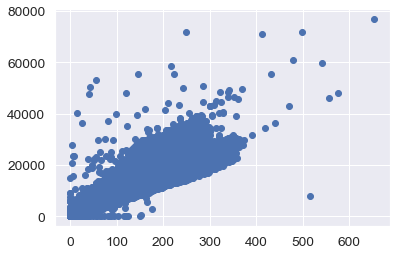

In [293]:
plt.scatter(data_19_final['VOLUME'],data_19_final['WEIGHT'])
plt.show()

In [294]:
df_4 = data_19_final
df_4['UNIT_VOLUME_WEIGHT'] = df_4['WEIGHT']/df_4['VOLUME']
def box_plot(df):
#     df = df[df['UNIT_VOLUME_WEIGHT'] != 0]
    Ser = df['UNIT_VOLUME_WEIGHT']
    Low = Ser.quantile(0.25)-1.5*(Ser.quantile(0.75)-Ser.quantile(0.25))
    Up = Ser.quantile(0.75)+1.5*(Ser.quantile(0.75)-Ser.quantile(0.25))
#     Mid = Ser.quantile(0.5)
    df = df[(df['UNIT_VOLUME_WEIGHT'] > Low) & (df['UNIT_VOLUME_WEIGHT'] < Up)]
    Mean = np.mean(df['UNIT_VOLUME_WEIGHT'])
    return Low, Up, Mean

Low_1 , Up_1, Mean_1 = box_plot(data_19_final[data_19_final['FREIGHT_BASIS'] == '轻货'])
Low_2 , Up_2, Mean_2 = box_plot(data_19_final[data_19_final['FREIGHT_BASIS'] == '重货'])

df_4['FIX_WEIGHT'] = df_4.apply(lambda x: x.VOLUME * Mean_1 if (x.UNIT_VOLUME_WEIGHT < Low_1) & (x.FREIGHT_BASIS == '轻货')
                               else x.VOLUME * Mean_2  if (x.UNIT_VOLUME_WEIGHT < Low_2) & (x.FREIGHT_BASIS == '重货')
                               else x.WEIGHT, axis = 1)
df_4['FIX_VOLUME'] = df_4.apply(lambda x: x.WEIGHT / Mean_1 if (x.UNIT_VOLUME_WEIGHT > Up_1) & (x.FREIGHT_BASIS == '轻货')
                               else x.WEIGHT / Mean_2 if (x.UNIT_VOLUME_WEIGHT > Up_2) & (x.FREIGHT_BASIS == '重货')
                               else x.VOLUME, axis =1)
df_4.head(1)
df_4.shape

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME,UNIT_VOLUME_WEIGHT,FIX_WEIGHT,FIX_VOLUME
0,T1702111035440,北辰区,5.28,368.5,55.0,0,17.5,117.324104,39.259106,3,5,5.562778,69.791667,368.5,5.28


(170820, 15)

In [281]:
data_19_final = df_4
data_19_final.columns

Index(['DO_NO', 'RECEIVE_STREET', 'VOLUME', 'WEIGHT', 'QUANTITY',
       'FREIGHT_BASIS', 'EQUIPMENT', 'ARRIVAL_LNG', 'ARRIVAL_LAT',
       'PICK_UP_Hour', 'RECEIVE_LATEST_Hour', 'UNLOAD_TIME',
       'UNIT_VOLUME_WEIGHT', 'FIX_WEIGHT', 'FIX_VOLUME'],
      dtype='object')

In [295]:
data_19_final = data_19_final[ ['DO_NO', 'RECEIVE_STREET',  'FIX_WEIGHT', 'FIX_VOLUME','UNIT_VOLUME_WEIGHT', 'QUANTITY',
       'FREIGHT_BASIS', 'EQUIPMENT', 'ARRIVAL_LNG', 'ARRIVAL_LAT',
       'PICK_UP_Hour', 'RECEIVE_LATEST_Hour', 'UNLOAD_TIME'
       ] ]
data_19_final.head(1)
data_19_final.shape

,DO_NO,RECEIVE_STREET,FIX_WEIGHT,FIX_VOLUME,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,368.5,5.28,69.791667,55.0,0,17.5,117.324104,39.259106,3,5,5.562778


(170820, 13)

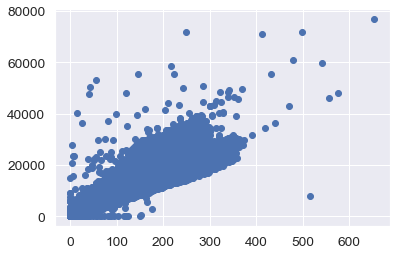

In [296]:
plt.scatter(data_19_final['FIX_VOLUME'],data_19_final['FIX_WEIGHT'])
plt.show()

In [297]:
data_19_final[(data_19_final['FIX_VOLUME']>500) & (data_19_final['FIX_WEIGHT']<20000)]

,DO_NO,RECEIVE_STREET,FIX_WEIGHT,FIX_VOLUME,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
152856,T1912087019568,泾渭街道,8029.43,515.385532,15.579463,4600.0,0,17.5,109.037966,34.536218,3,3,22.514444


In [298]:
data_19_final = data_19_final.drop(index=[152856])
data_19_final.shape

(170819, 13)

In [299]:
data_19_final[(data_19_final['FIX_VOLUME']>500) & (data_19_final['FIX_WEIGHT']<20000)]

,DO_NO,RECEIVE_STREET,FIX_WEIGHT,FIX_VOLUME,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME


In [300]:
data_19_final_test = data_19_final[(data_19_final['FIX_VOLUME']>1) & (data_19_final['FIX_WEIGHT']>1)]
data_19_final_test.shape

(161308, 13)

In [301]:
data_19_final.shape

(170819, 13)

In [306]:
data_19_final_test = data_19_final[(data_19_final['FIX_VOLUME']>0) & (data_19_final['FIX_WEIGHT']>0)]
data_19_final_test.shape

(170633, 13)

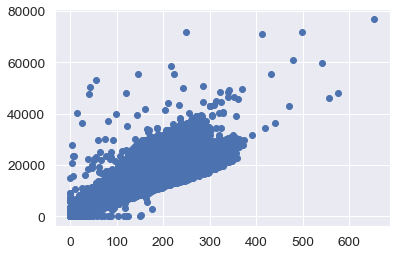

In [307]:
plt.scatter(data_19_final_test['FIX_VOLUME'],data_19_final_test['FIX_WEIGHT'])
plt.show()

In [308]:
data_19_final = data_19_final_test     #  异常体积处理完毕

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


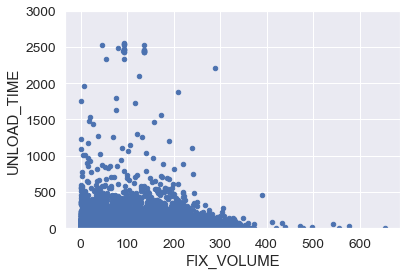

In [318]:
var = 'FIX_VOLUME'
data = pd.concat([data_19_final['UNLOAD_TIME'], data_19_final[var]], axis=1)    #  对结果表示  不能理解。。
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,3000));

In [314]:
data_19_final['UNLOAD_TIME'].max()
data_19_final['FIX_VOLUME'].min()
data_19_final['FIX_WEIGHT'].min()

15269.381944444443

0.0001

0.1

In [315]:
data_19_final = data_19_final[(data_19_final['FIX_VOLUME']>0.099) & (data_19_final['FIX_WEIGHT']>0.099)]
data_19_final.shape

(169509, 13)

In [316]:
data_19_final['UNLOAD_TIME'].max()
data_19_final['FIX_VOLUME'].min()
data_19_final['FIX_WEIGHT'].min()

15269.381944444443

0.099235

0.44

In [319]:
data_19_final = data_19_final[data_19_final['FIX_VOLUME'] < 400]
data_19_final = data_19_final[data_19_final['UNLOAD_TIME'] < 2500]
data_19_final.shape

(169476, 13)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


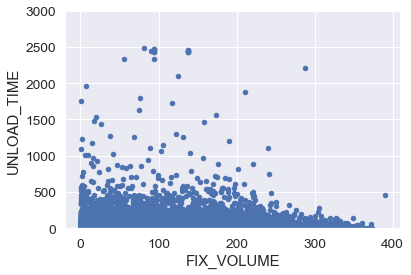

In [320]:
var = 'FIX_VOLUME'
data = pd.concat([data_19_final['UNLOAD_TIME'], data_19_final[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,3000));

In [321]:
data_19_final.columns

Index(['DO_NO', 'RECEIVE_STREET', 'FIX_WEIGHT', 'FIX_VOLUME',
       'UNIT_VOLUME_WEIGHT', 'QUANTITY', 'FREIGHT_BASIS', 'EQUIPMENT',
       'ARRIVAL_LNG', 'ARRIVAL_LAT', 'PICK_UP_Hour', 'RECEIVE_LATEST_Hour',
       'UNLOAD_TIME'],
      dtype='object')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


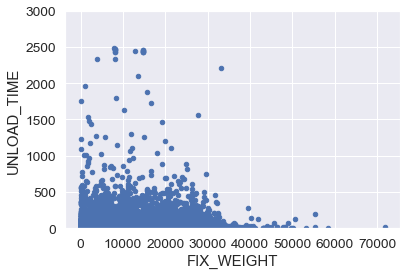

In [322]:
var = 'FIX_WEIGHT'
data = pd.concat([data_19_final['UNLOAD_TIME'], data_19_final[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,3000));

In [325]:
data_19_final = data_19_final[data_19_final['FIX_WEIGHT'] < 40000]
data_19_final.shape

(169443, 13)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


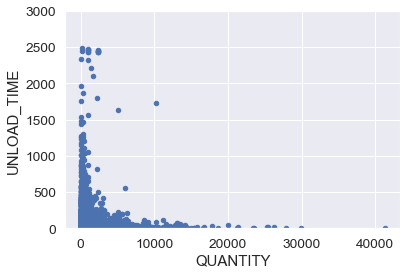

In [326]:
var = 'QUANTITY'
data = pd.concat([data_19_final['UNLOAD_TIME'], data_19_final[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,3000));

In [331]:
data_19_final = data_19_final[data_19_final['QUANTITY'] < 12000]
data_19_final.shape

(169392, 13)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


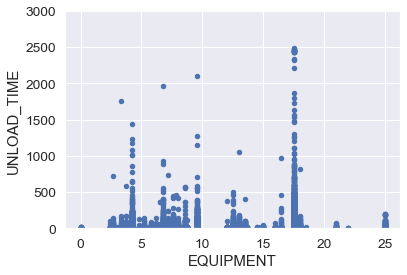

In [332]:
var = 'EQUIPMENT'
data = pd.concat([data_19_final['UNLOAD_TIME'], data_19_final[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,3000));

没啥好动的。。。

###  处理偏度和峰度

In [334]:
cols = ('FIX_WEIGHT', 'FIX_VOLUME', 'UNIT_VOLUME_WEIGHT','QUANTITY','EQUIPMENT','ARRIVAL_LNG',
        'ARRIVAL_LAT','PICK_UP_Hour','RECEIVE_LATEST_Hour','UNLOAD_TIME')
# 'FIX_WEIGHT', 'FIX_VOLUME', 'UNIT_VOLUME_WEIGHT'

for c in cols:
    data_19_final[c] = data_19_final[c].astype('float64')
    data_19_final[c] = np.log(data_19_final[c])
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,FIX_WEIGHT,FIX_VOLUME,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,5.909441,1.663926,4.245515,4.007333,0,2.862201,4.76494,3.670183,1.098612,1.609438,1.716098


In [335]:
data_19_final.head()
data_19_final.shape

,DO_NO,RECEIVE_STREET,FIX_WEIGHT,FIX_VOLUME,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,5.909441,1.663926,4.245515,4.007333,0,2.862201,4.764940,3.670183,1.098612,1.609438,1.716098
1,T1702111035818,亭湖区,7.698029,3.613011,4.085019,4.605170,0,2.862201,4.789690,3.509807,1.098612,1.609438,1.714748
2,T1702111035868,灯塔,4.430817,0.398382,4.032435,1.098612,0,2.862201,4.693674,3.322808,1.098612,1.609438,1.715398
3,T1707271604891,钟岭街道办事处（金巢开发区）,7.718685,3.087091,4.631594,3.912023,0,2.862201,4.756842,3.330696,1.609438,1.609438,-0.288794
4,T1707281606693,九龙镇,8.294050,3.727213,4.566837,4.605170,0,2.862201,4.735250,3.547395,1.609438,1.609438,-0.288794


(169392, 13)

In [336]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

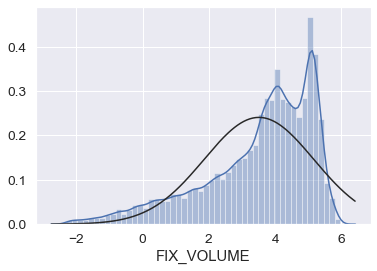

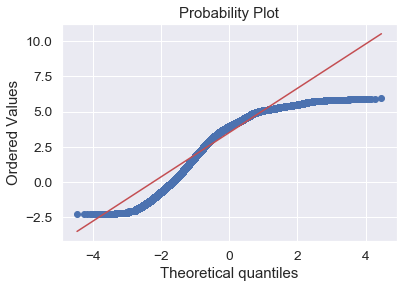

In [338]:
sns.distplot(data_19_final['FIX_VOLUME'], fit = norm);
fig = plt.figure()
res = stats.probplot(data_19_final['FIX_VOLUME'], plot=plt)

In [340]:
# data_19_final.min()

data_19_final = data_19_final.replace([np.inf, -np.inf], 0)      #  替换掉 负无穷值
data_19_final.min()

DO_NO                  T1702111035440
RECEIVE_STREET                  丁字湾街道
FIX_WEIGHT                  -0.820981
FIX_VOLUME                   -2.31026
UNIT_VOLUME_WEIGHT         -0.0591369
QUANTITY                            0
FREIGHT_BASIS                       0
EQUIPMENT                           0
ARRIVAL_LNG                   4.33038
ARRIVAL_LAT                   2.97235
PICK_UP_Hour                        0
RECEIVE_LATEST_Hour                 0
UNLOAD_TIME                  -6.57925
dtype: object

#####  归一化

In [341]:
cols = ('FIX_WEIGHT', 'FIX_VOLUME', 'UNIT_VOLUME_WEIGHT','QUANTITY','EQUIPMENT','ARRIVAL_LNG',
        'ARRIVAL_LAT','PICK_UP_Hour','RECEIVE_LATEST_Hour','UNLOAD_TIME')

for c in cols:
    Stds = StandardScaler()
#     Stds.fit(list(df_train[c].values))
#     df_train[c] = Stds.transform(list(df_train[c].values))
    data_19_final[c] = Stds.fit_transform(data_19_final[c][:,np.newaxis])  #  这里用法很好
data_19_final.head(1)

,DO_NO,RECEIVE_STREET,FIX_WEIGHT,FIX_VOLUME,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,-1.432244,-1.114322,-1.398548,-0.581258,0,0.640064,0.470566,1.241664,0.074329,0.619033,0.052832


In [209]:
# data_19_final['RECEIVE_LATEST_Hour'] = StandardScaler().fit_transform(data_19_final['RECEIVE_LATEST_Hour'][:,np.newaxis])
# data_19_final.head(1)

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,-1.02096,-1.09193,-0.289372,0,0.645896,0.470339,1.241094,0.070069,0.620049,0.062136


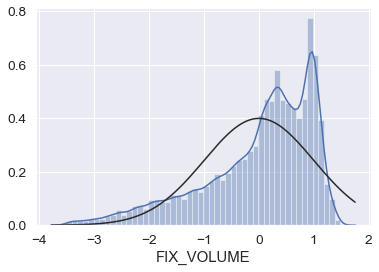

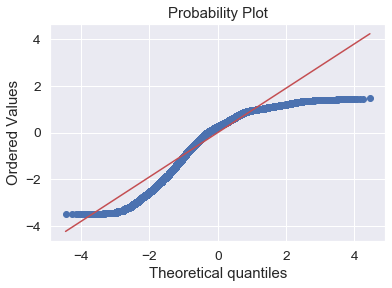

In [342]:
sns.distplot(data_19_final['FIX_VOLUME'], fit = norm);
fig = plt.figure()
res = stats.probplot(data_19_final['FIX_VOLUME'], plot=plt)

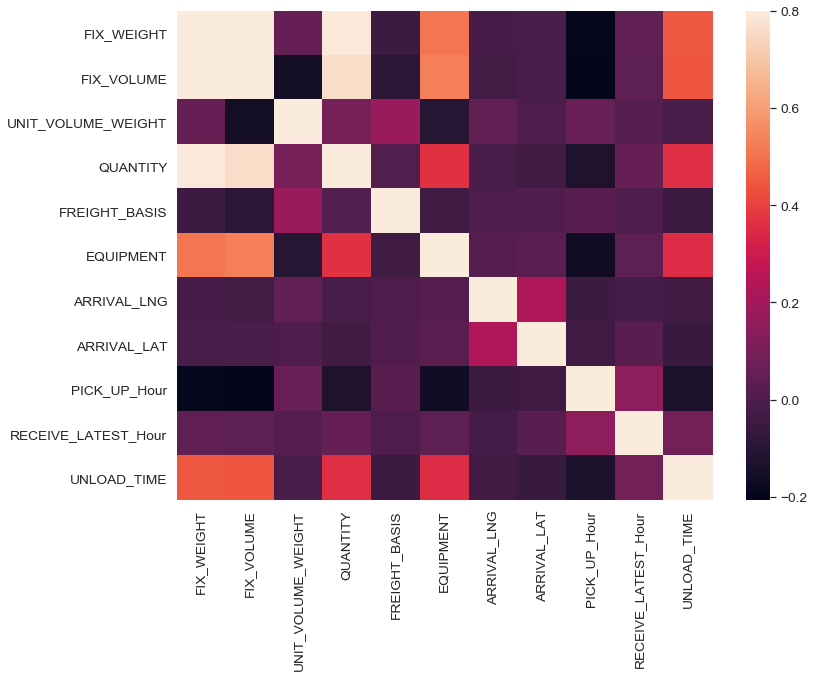

In [343]:
corrmat  = data_19_final.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8)

In [346]:
k = 10 
cols_test = corrmat.nlargest(k, 'UNLOAD_TIME')['UNLOAD_TIME']
cols_test
# cols = corrmat.nlargest(k, 'UNLOAD_TIME')['UNLOAD_TIME'].index
# cm = np.corrcoef(data_19_final[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

UNLOAD_TIME            1.000000
FIX_WEIGHT             0.446698
FIX_VOLUME             0.444504
QUANTITY               0.360241
EQUIPMENT              0.353122
RECEIVE_LATEST_Hour    0.090302
UNIT_VOLUME_WEIGHT    -0.011763
ARRIVAL_LNG           -0.032296
FREIGHT_BASIS         -0.049525
ARRIVAL_LAT           -0.055814
Name: UNLOAD_TIME, dtype: float64

In [351]:
data_19_final.columns

Index(['DO_NO', 'RECEIVE_STREET', 'FIX_WEIGHT', 'FIX_VOLUME',
       'UNIT_VOLUME_WEIGHT', 'QUANTITY', 'FREIGHT_BASIS', 'EQUIPMENT',
       'ARRIVAL_LNG', 'ARRIVAL_LAT', 'PICK_UP_Hour', 'RECEIVE_LATEST_Hour',
       'UNLOAD_TIME'],
      dtype='object')

In [213]:
data_19_final.head()

,DO_NO,RECEIVE_STREET,VOLUME,WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,-1.020960,-1.091930,-0.289372,0,0.645896,0.470339,1.241094,0.070069,0.620049,0.062136
1,T1702111035818,亭湖区,0.150813,-0.130257,0.005120,0,0.645896,0.916275,0.347562,0.070069,0.620049,0.061167
2,T1702111035868,灯塔,-3.181342,-2.139270,-3.030011,0,0.645896,-0.813728,-0.694295,0.070069,0.620049,0.061634
3,T1707271604891,钟岭街道办事处（金巢开发区）,-0.086926,-0.120511,-0.340351,0,0.645896,0.324426,-0.650346,1.388667,0.620049,-1.378061
4,T1707281606693,九龙镇,0.197843,0.140969,0.005120,0,0.645896,-0.064623,0.556980,1.388667,0.620049,-1.378061


In [347]:
data_19_final.head()
data_19_final.shape

,DO_NO,RECEIVE_STREET,FIX_WEIGHT,FIX_VOLUME,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour,UNLOAD_TIME
0,T1702111035440,北辰区,-1.432244,-1.114322,-1.398548,-0.581258,0,0.640064,0.470566,1.241664,0.074329,0.619033,0.052832
1,T1702111035818,亭湖区,-0.341151,0.062052,-1.846082,-0.232831,0,0.640064,0.916238,0.347719,0.074329,0.619033,0.051851
2,T1702111035868,灯塔,-2.334249,-1.878144,-1.992709,-2.276496,0,0.640064,-0.812742,-0.694618,0.074329,0.619033,0.052324
3,T1707271604891,钟岭街道办事处（金巢开发区）,-0.328550,-0.255368,-0.321988,-0.636806,0,0.640064,0.324739,-0.650649,1.392285,0.619033,-1.404605
4,T1707281606693,九龙镇,0.022439,0.130978,-0.502559,-0.232831,0,0.640064,-0.064079,0.557234,1.392285,0.619033,-1.404605


(169392, 13)

In [348]:
# data_19_final.max()

total = data_19_final.isnull().sum().sort_values(ascending=False)
total

UNLOAD_TIME            17
ARRIVAL_LAT             8
ARRIVAL_LNG             8
RECEIVE_LATEST_Hour     0
PICK_UP_Hour            0
EQUIPMENT               0
FREIGHT_BASIS           0
QUANTITY                0
UNIT_VOLUME_WEIGHT      0
FIX_VOLUME              0
FIX_WEIGHT              0
RECEIVE_STREET          0
DO_NO                   0
dtype: int64

In [349]:
data_19_final.fillna(0.01, inplace=True) # 填充均值

In [350]:
# data_19_final.max()

total = data_19_final.isnull().sum().sort_values(ascending=False)
total

UNLOAD_TIME            0
RECEIVE_LATEST_Hour    0
PICK_UP_Hour           0
ARRIVAL_LAT            0
ARRIVAL_LNG            0
EQUIPMENT              0
FREIGHT_BASIS          0
QUANTITY               0
UNIT_VOLUME_WEIGHT     0
FIX_VOLUME             0
FIX_WEIGHT             0
RECEIVE_STREET         0
DO_NO                  0
dtype: int64

In [352]:
# ['DO_NO', 'RECEIVE_STREET', 'FIX_WEIGHT', 'FIX_VOLUME',
#        'UNIT_VOLUME_WEIGHT', 'QUANTITY', 'FREIGHT_BASIS', 'EQUIPMENT',
#        'ARRIVAL_LNG', 'ARRIVAL_LAT', 'PICK_UP_Hour', 'RECEIVE_LATEST_Hour',
#        'UNLOAD_TIME']

x = data_19_final[['FIX_VOLUME', 'FIX_WEIGHT','UNIT_VOLUME_WEIGHT', 'QUANTITY',
       'FREIGHT_BASIS', 'EQUIPMENT', 'ARRIVAL_LNG', 'ARRIVAL_LAT',
       'PICK_UP_Hour', 'RECEIVE_LATEST_Hour']]
y = data_19_final['UNLOAD_TIME']

In [353]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [354]:
y_train.values
pd.DataFrame(y_train.head())

array([ 0.17057241,  0.08832377,  0.390114  , ..., -2.43563839,
       -1.7993173 , -1.18444312])

,UNLOAD_TIME
113672,0.170572
48810,0.088324
16799,0.390114
4742,1.515759
58113,-0.643782


In [355]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import explained_variance_score

In [356]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [357]:
model_1 = Lasso(alpha =0.0005, random_state=1)
model_1.fit(x_train, y_train.values)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [358]:
y_pred = model_1.predict(x_test)
# y_pred
print("explained_variance_score: {:<8.5f}".format(explained_variance_score(y_test.values,y_pred)))  

explained_variance_score: 0.23447 


In [359]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [360]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [361]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [398]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=5, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=0,
                             random_state =7, nthread = -1)

In [363]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [364]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.8745 (0.0029)



In [237]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[23:03:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:05:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:06:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [399]:
model_xgb.fit(x_train,y_train.values)
y_pred = model_xgb.predict(x_test)
print("explained_variance_score_xgb: {:<8.5f}".format(explained_variance_score(y_test.values,y_pred)))

[15:28:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=0, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

explained_variance_score_xgb: 0.60210 


In [241]:
model_lgb.fit(x_train,y_train.values)
y_pred = model_lgb.predict(x_test)
print("explained_variance_score: {:<8.5f}".format(explained_variance_score(y_test.values,y_pred)))

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

explained_variance_score: 0.47363 


In [366]:
#  31  上午 清洗后结果
model_lgb.fit(x_train,y_train.values)
y_pred = model_lgb.predict(x_test)
print("explained_variance_score: {:<8.5f}".format(explained_variance_score(y_test.values,y_pred)))

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

explained_variance_score: 0.47942 


#####  下一步，可以考虑
(1) 进一步清洗下数据

(2) 调参
。。。

#####   学习曲线，调参

In [377]:
from sklearn.model_selection import learning_curve

In [379]:
learning_curve??

In [380]:
x.head()
y.head()

,FIX_VOLUME,FIX_WEIGHT,UNIT_VOLUME_WEIGHT,QUANTITY,FREIGHT_BASIS,EQUIPMENT,ARRIVAL_LNG,ARRIVAL_LAT,PICK_UP_Hour,RECEIVE_LATEST_Hour
0,-1.114322,-1.432244,-1.398548,-0.581258,0,0.640064,0.470566,1.241664,0.074329,0.619033
1,0.062052,-0.341151,-1.846082,-0.232831,0,0.640064,0.916238,0.347719,0.074329,0.619033
2,-1.878144,-2.334249,-1.992709,-2.276496,0,0.640064,-0.812742,-0.694618,0.074329,0.619033
3,-0.255368,-0.328550,-0.321988,-0.636806,0,0.640064,0.324739,-0.650649,1.392285,0.619033
4,0.130978,0.022439,-0.502559,-0.232831,0,0.640064,-0.064079,0.557234,1.392285,0.619033


0    0.052832
1    0.051851
2    0.052324
3   -1.404605
4   -1.404605
Name: UNLOAD_TIME, dtype: float64

[10:34:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:35:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:35:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[10:58:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:00:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:02:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[11:24:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:25:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:26:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

Text(0.5, 0, 'traing examples')

Text(0, 0.5, 'error')

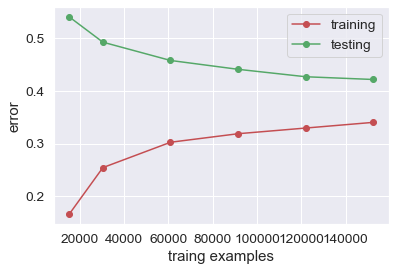

In [385]:
X = x
y = y
# scoring='explained_variance_score'

train_sizes,train_score,test_score = learning_curve(model_xgb,X,y,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=10,)
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

"\nbase_score=0.5, booster='gbtree', colsample_bylevel=1,\n             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,\n             gpu_id=-1, importance_type='gain', interaction_constraints='',\n             learning_rate=0.05, max_delta_step=0, max_depth=5,\n             min_child_weight=1.7817, missing=nan, monotone_constraints='()',\n             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,\n             objective='reg:squarederror', random_state=7, reg_alpha=0.464,\n             reg_lambda=0.8571, scale_pos_weight=1, silent=0, subsample=0.5213,\n             tree_method='exact', validate_parameters=1, verbosity=Nonef\n"

[13:40:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

Text(0.5, 0, 'number of tree')

Text(0, 0.5, 'accuracy')

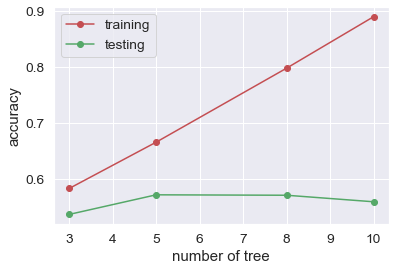

In [387]:
from sklearn.model_selection import validation_curve

'''
base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=0, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=Nonef
'''

param_range = [3,5,8,10]
train_score,test_score = validation_curve(model_xgb,X,y,param_name='max_depth',param_range=param_range,cv=5)
train_score =  np.mean(train_score,axis=1)
test_score = np.mean(test_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'training')
plt.plot(param_range,test_score,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('number of tree')    #  这里没改  应该是树的深度  max_depth 
plt.ylabel('accuracy')
plt.show()

上图可见，max_depth   取值为 5 或者 8 时，测试集效果较好。